# Re-rating with RoBERTa

Using our trained RoBERTa model to re-assign a star rating to each review and re-rate the restaurant.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

plt.style.use('ggplot')

import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [2]:
# Read in reviews data from csv

df = pd.read_csv('/data/processed/bangia_reviews.csv')

In [3]:
# Show the first few rows

df.head()

,Id,rating,text
0,1,5,This is great lowkey spot in Ktown. They have ...
1,2,5,The food was flavorful and the vibes was nice ...
2,3,5,Discovered Manhattan’s first soju smoothie wit...
3,4,5,"As a Korean girl, I only came here because my ..."
4,5,5,The alcoholic bingsoo a were great. Our favori...


In [4]:
# Check the size of the dataset

print(df.shape)

(645, 3)


## What does the dataset look like

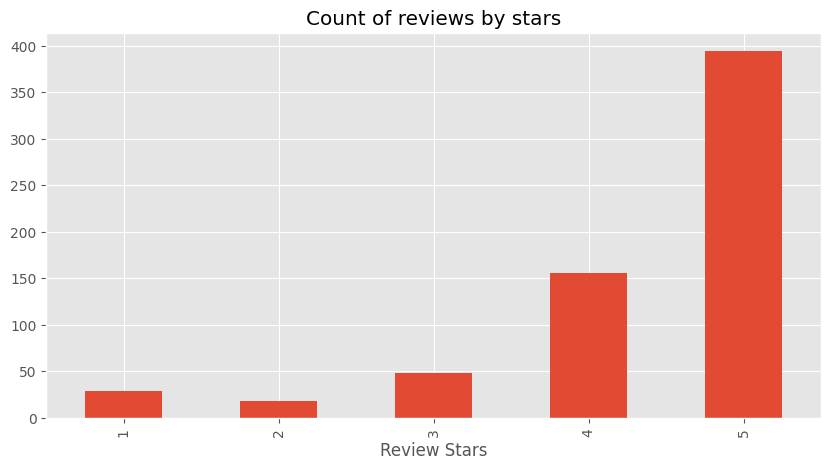

In [5]:
ax = df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of reviews by stars',
          figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

In [6]:
# Make a new dataframe of just the reviews that have comments
mask_nan = pd.notna(df['text'])
df_com = df[mask_nan]
print(df_com.shape)

(344, 3)


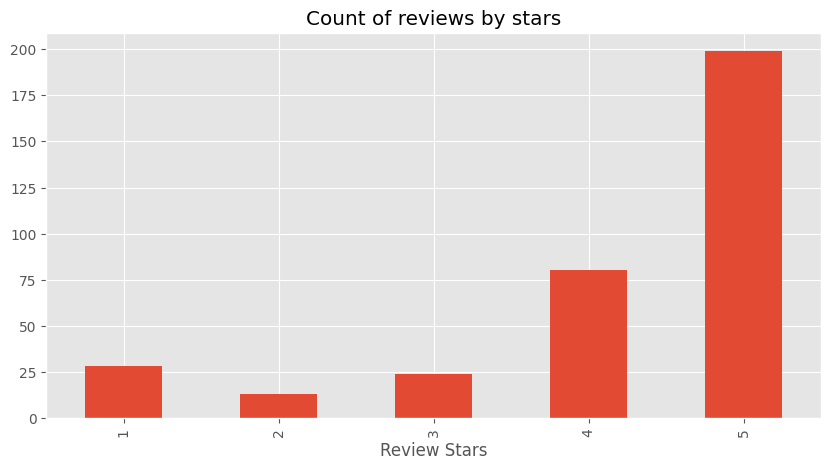

In [7]:
ax = df_com['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of reviews by stars',
          figsize = (10,5))
ax.set_xlabel('Review Stars')
plt.show()

## Roberta from Huggingface

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

from tqdm.notebook import tqdm # Progress bar tracker

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [9]:
# Download the model and tokenizer

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [10]:
# Function for getting roberta scores

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt') # 'pt' is for pytorch
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [11]:
res = {}
for i, row in tqdm(df_com.iterrows(), total=len(df_com)):
    try:
        text = row['text']
        myid = row['Id']
        roberta_result = polarity_scores_roberta(text)
        res[myid] = roberta_result
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/344 [00:00<?, ?it/s]

In [12]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df_com, how='left')

In [13]:
results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,rating,text
0,1,0.001094,0.007240,0.991666,5,This is great lowkey spot in Ktown. They have ...
1,2,0.221688,0.329477,0.448835,5,The food was flavorful and the vibes was nice ...
2,3,0.001020,0.009537,0.989442,5,Discovered Manhattan’s first soju smoothie wit...
3,4,0.001369,0.006198,0.992433,5,"As a Korean girl, I only came here because my ..."
4,5,0.001127,0.006433,0.992441,5,The alcoholic bingsoo a were great. Our favori...


## Analysis

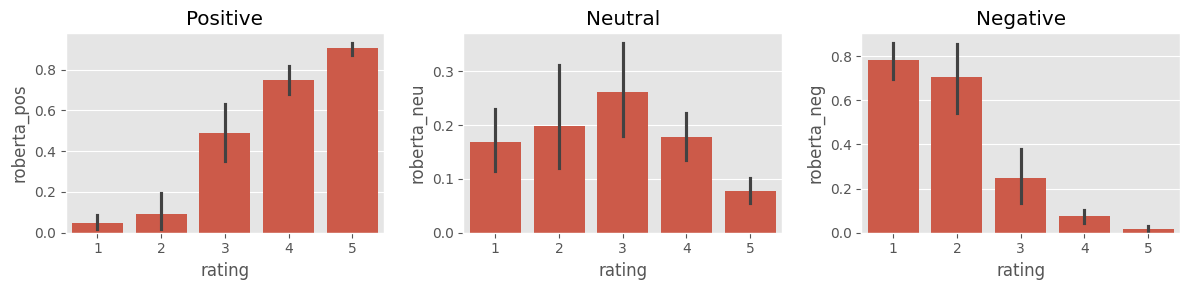

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='rating', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='rating', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='rating', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

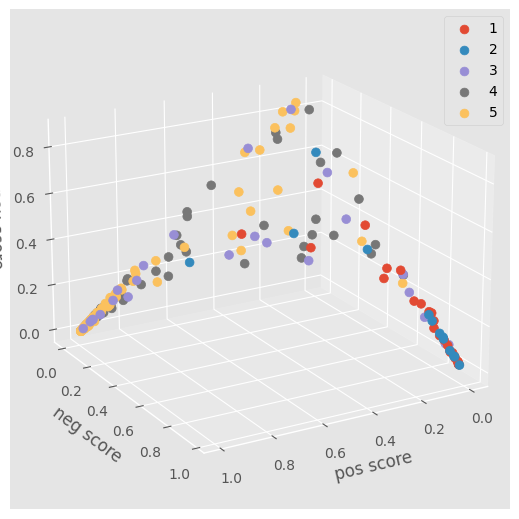

In [15]:
fig = plt.figure(figsize=(5,5))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

cut1 = results_df['rating']==1
cut2 = results_df['rating']==2
cut3 = results_df['rating']==3
cut4 = results_df['rating']==4
cut5 = results_df['rating']==5

sc = ax.scatter(results_df['roberta_pos'][cut1], results_df['roberta_neg'][cut1], results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
sc = ax.scatter(results_df['roberta_pos'][cut2], results_df['roberta_neg'][cut2], results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
sc = ax.scatter(results_df['roberta_pos'][cut3], results_df['roberta_neg'][cut3], results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
sc = ax.scatter(results_df['roberta_pos'][cut4], results_df['roberta_neg'][cut4], results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
sc = ax.scatter(results_df['roberta_pos'][cut5], results_df['roberta_neg'][cut5], results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

ax.set_xlabel('pos score')
ax.set_ylabel('neg score')
ax.set_zlabel('neu score')

ax.view_init(20, 60)

plt.legend()

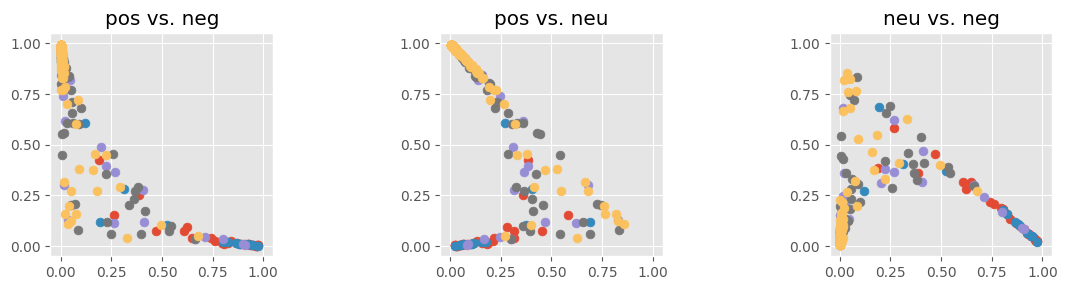

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

axs[0].scatter(results_df['roberta_neg'][cut1], results_df['roberta_pos'][cut1], s=40, c='C0', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut2], results_df['roberta_pos'][cut2], s=40, c='C1', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut3], results_df['roberta_pos'][cut3], s=40, c='C2', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut4], results_df['roberta_pos'][cut4], s=40, c='C3', marker='o', alpha=1)
axs[0].scatter(results_df['roberta_neg'][cut5], results_df['roberta_pos'][cut5], s=40, c='C4', marker='o', alpha=1)

axs[1].scatter(results_df['roberta_neu'][cut1], results_df['roberta_pos'][cut1], s=40, c='C0', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut2], results_df['roberta_pos'][cut2], s=40, c='C1', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut3], results_df['roberta_pos'][cut3], s=40, c='C2', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut4], results_df['roberta_pos'][cut4], s=40, c='C3', marker='o', alpha=1)
axs[1].scatter(results_df['roberta_neu'][cut5], results_df['roberta_pos'][cut5], s=40, c='C4', marker='o', alpha=1)

axs[2].scatter(results_df['roberta_neg'][cut1], results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut2], results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut3], results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut4], results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1)
axs[2].scatter(results_df['roberta_neg'][cut5], results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1)

axs[0].set(aspect='equal')
axs[1].set(aspect='equal')
axs[2].set(aspect='equal')

axs[0].set_xlim(-0.05, 1.05)
axs[1].set_xlim(-0.05, 1.05)
axs[2].set_xlim(-0.05, 1.05)

axs[0].set_ylim(-0.05, 1.05)
axs[1].set_ylim(-0.05, 1.05)
axs[2].set_ylim(-0.05, 1.05)

axs[0].set_xticks(np.arange(0, 1.01, .25))
axs[1].set_xticks(np.arange(0, 1.01, .25))
axs[2].set_xticks(np.arange(0, 1.01, .25))

axs[0].set_yticks(np.arange(0, 1.01, .25))
axs[1].set_yticks(np.arange(0, 1.01, .25))
axs[2].set_yticks(np.arange(0, 1.01, .25))

axs[0].set_title('pos vs. neg')
axs[1].set_title('pos vs. neu')
axs[2].set_title('neu vs. neg')
plt.tight_layout()
plt.show()

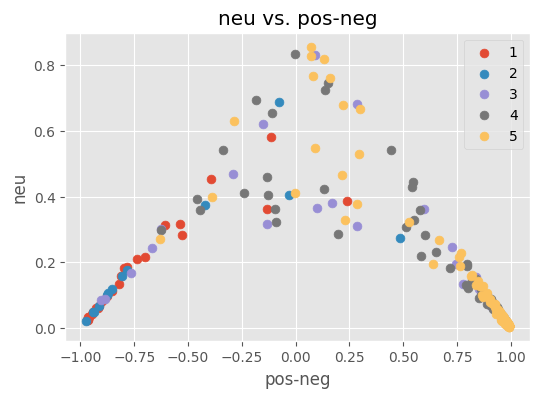

In [17]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos'][cut1]-results_df['roberta_neg'][cut1], results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
plt.scatter(results_df['roberta_pos'][cut2]-results_df['roberta_neg'][cut2], results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
plt.scatter(results_df['roberta_pos'][cut3]-results_df['roberta_neg'][cut3], results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
plt.scatter(results_df['roberta_pos'][cut4]-results_df['roberta_neg'][cut4], results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
plt.scatter(results_df['roberta_pos'][cut5]-results_df['roberta_neg'][cut5], results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

plt.title('neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('neu')

plt.legend()

plt.show()

Let's check that pos+neg+neu does in fact equal 1

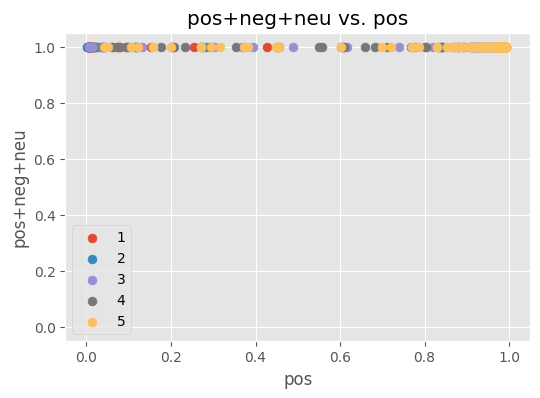

In [18]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos'][cut1], results_df['roberta_pos'][cut1]+results_df['roberta_neg'][cut1]+results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
plt.scatter(results_df['roberta_pos'][cut2], results_df['roberta_pos'][cut2]+results_df['roberta_neg'][cut2]+results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
plt.scatter(results_df['roberta_pos'][cut3], results_df['roberta_pos'][cut3]+results_df['roberta_neg'][cut3]+results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
plt.scatter(results_df['roberta_pos'][cut4], results_df['roberta_pos'][cut4]+results_df['roberta_neg'][cut4]+results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
plt.scatter(results_df['roberta_pos'][cut5], results_df['roberta_pos'][cut5]+results_df['roberta_neg'][cut5]+results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)

plt.title('pos+neg+neu vs. pos')
plt.xlabel('pos')
plt.ylabel('pos+neg+neu')

plt.legend()

plt.show()

Good.

Now, since these points exist in the plane pos+neg+neu=1, lets look at how they look *in that plane* by choosing a new basis \
\
This plane is perpendicular to the vector [1,1,1].
The horizontal vector in this plane is [1,-1,0], so the vertical vector is the cross product, which is [1, 1, -2]. \
\
So we plot pos+neg-2*neu vs. pos-neg.

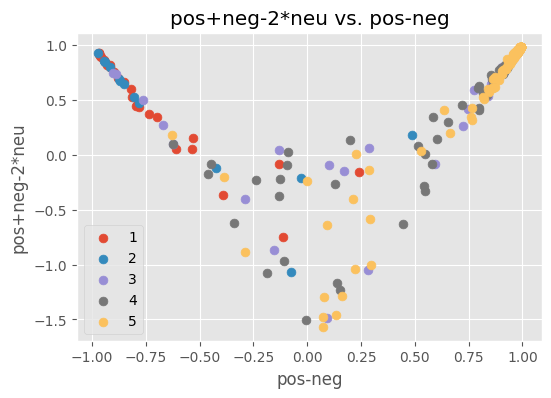

In [19]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos'][cut1]-results_df['roberta_neg'][cut1], results_df['roberta_pos'][cut1]+results_df['roberta_neg'][cut1]-2*results_df['roberta_neu'][cut1], s=40, c='C0', marker='o', alpha=1, label = '1')
plt.scatter(results_df['roberta_pos'][cut2]-results_df['roberta_neg'][cut2], results_df['roberta_pos'][cut2]+results_df['roberta_neg'][cut2]-2*results_df['roberta_neu'][cut2], s=40, c='C1', marker='o', alpha=1, label = '2')
plt.scatter(results_df['roberta_pos'][cut3]-results_df['roberta_neg'][cut3], results_df['roberta_pos'][cut3]+results_df['roberta_neg'][cut3]-2*results_df['roberta_neu'][cut3], s=40, c='C2', marker='o', alpha=1, label = '3')
plt.scatter(results_df['roberta_pos'][cut4]-results_df['roberta_neg'][cut4], results_df['roberta_pos'][cut4]+results_df['roberta_neg'][cut4]-2*results_df['roberta_neu'][cut4], s=40, c='C3', marker='o', alpha=1, label = '4')
plt.scatter(results_df['roberta_pos'][cut5]-results_df['roberta_neg'][cut5], results_df['roberta_pos'][cut5]+results_df['roberta_neg'][cut5]-2*results_df['roberta_neu'][cut5], s=40, c='C4', marker='o', alpha=1, label = '5')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

plt.legend()

plt.show()

Let's try a hyperbolic best fit to this scatterplot

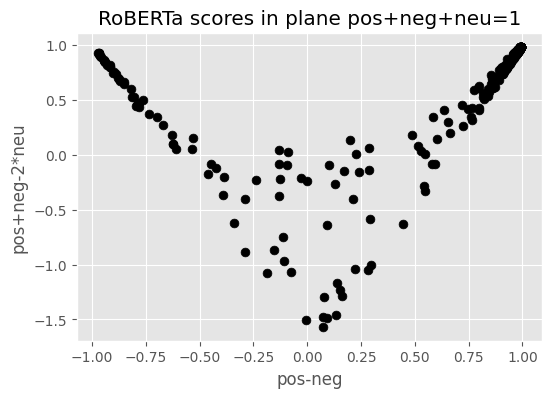

In [20]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos']-results_df['roberta_neg'], results_df['roberta_pos']+results_df['roberta_neg']-2*results_df['roberta_neu'], s=40, c='k', marker='o', alpha=1, label = 'data')

plt.title('RoBERTa scores in plane pos+neg+neu=1')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

#plt.legend()

plt.show()

In [21]:
# Make values into numpy arrays
x_values = results_df['roberta_pos'].to_numpy()-results_df['roberta_neg'].to_numpy()
y_values = results_df['roberta_pos'].to_numpy()+results_df['roberta_neg'].to_numpy()-2*results_df['roberta_neu'].to_numpy()

# Define the fitting function
def hyperbola(x, a, b, k):
  return b*np.sqrt(1+x**2/a**2)+k

# Do the fit
popt, _ = curve_fit(hyperbola, x_values, y_values)

# Unpack the results
a, b, k = popt

# Make the best fit line into plottable data
x_fit = np.arange(-1., 1.01, 0.01)
y_fit = hyperbola(x_fit, a, b, k)

In [22]:
print('Old a, b, k = -0.5508669146140227 1.345497444368229 -1.7984662953417951')

Old a, b, k = -0.5508669146140227 1.345497444368229 -1.7984662953417951


In [23]:
print(a, b, k)

-0.3380436921830205 0.8221133140248826 -1.5755215390747053


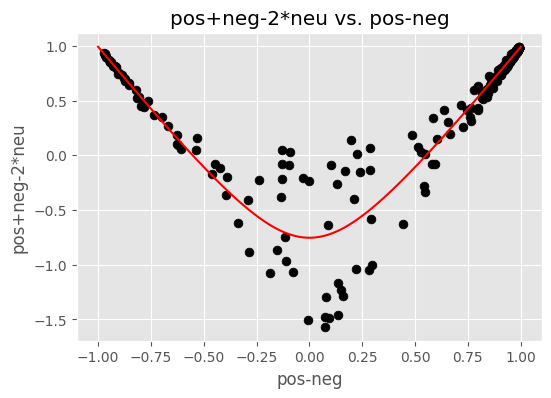

In [24]:
fig = plt.figure(figsize=(6,4))

plt.scatter(results_df['roberta_pos']-results_df['roberta_neg'], results_df['roberta_pos']+results_df['roberta_neg']-2*results_df['roberta_neu'], s=40, c='k', marker='o', alpha=1, label = 'data')
plt.plot(x_fit, y_fit, c='red')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

#plt.legend()

plt.show()

There is no analytic solution to the arc length of part of a hyperbola, so let's find each percentile of the arc length analytically. \

\
Each 2% of the arc will be 0.1 stars.

In [25]:
xs_hyp = np.arange(-1., 1.001, 0.001)
ys_hyp = hyperbola(xs_hyp, a, b, k)
cumlen = np.zeros(xs_hyp.size)
a_size = xs_hyp.size

for i in range(xs_hyp.size-1):
  len = np.sqrt((xs_hyp[i+1]-xs_hyp[i])**2 + (ys_hyp[i+1]-ys_hyp[i])**2)
  cumlen[-a_size+1+i:] = np.add(cumlen[-a_size+1+i:], len*np.ones(a_size-1-i))

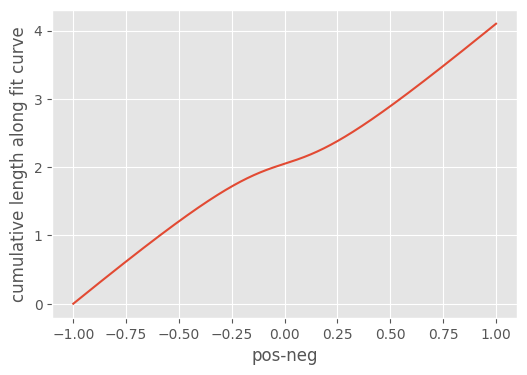

In [26]:
fig = plt.figure(figsize=(6,4))

plt.plot(xs_hyp, cumlen)

plt.xlabel('pos-neg')
plt.ylabel('cumulative length along fit curve')

plt.show()

## Rescaling from 1 to 5 stars

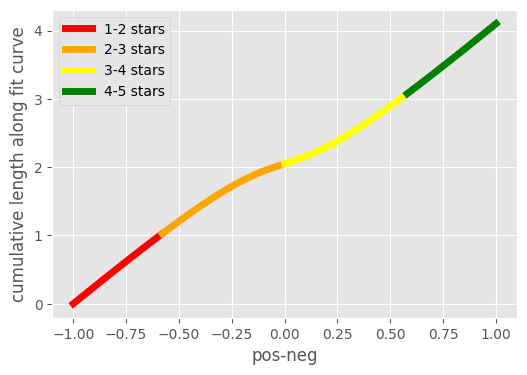

In [27]:
# Showing what each amount of stars will look like according to this plot
max = np.max(cumlen)

cutoff_2_3 = np.argmax(cumlen>0.25*max)-1
cutoff_3_4 = np.argmax(cumlen>0.5*max)-1
cutoff_4_5 = np.argmax(cumlen>0.75*max)-1

fig = plt.figure(figsize=(6,4))

plt.plot(xs_hyp[:cutoff_2_3], cumlen[:cutoff_2_3], linewidth=5, c='red', label='1-2 stars')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], cumlen[cutoff_2_3+1:cutoff_3_4], linewidth=5, c='orange', label='2-3 stars')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], cumlen[cutoff_3_4+1:cutoff_4_5], linewidth=5, c='yellow', label='3-4 stars')
plt.plot(xs_hyp[cutoff_4_5+1:], cumlen[cutoff_4_5+1:], linewidth=5, c='green', label='4-5 stars')

plt.xlabel('pos-neg')
plt.ylabel('cumulative length along fit curve')

plt.legend()

plt.show()

In [28]:
# Define functions for finding closest point on fit curve

# Dist squared formula
def dist2(x1, y1, x2, y2):
    return (x2-x1)**2+(y2-y1)**2

# Index of closest point on curve
def closest(x, y, xs, ys):
    dist = dist2(x, y, xs[0], ys[0])
    ind_close = 0
    for i in range(1, xs.shape[0]):
        new_dist = dist2(x, y, xs[i], ys[i])
        if new_dist < dist:
            dist = new_dist
            ind_close = i
    return ind_close

## Assigning each review its closest point on the fit curve

In [29]:
res = {}
for i, row in tqdm(results_df.iterrows(), total=results_df.shape[0]):
    try:
        myid = row['Id']
        pos = row['roberta_pos']
        neg = row['roberta_neg']
        neu = row['roberta_neu']
        pos_neg = pos-neg
        pos_neg_2neu = pos+neg-2*neu

        ind_close = closest(pos_neg, pos_neg_2neu, xs_hyp, ys_hyp)
        star = round(4.0*(cumlen[ind_close]/np.max(cumlen)), 1) + 1. # 4*frac+1 because 1<=stars<=5

        restar_dict = {
            'pos_neg' : pos_neg,
            'pos_neg_2neu' : pos_neg_2neu,
            'new_stars' : star
        }
        res[myid] = restar_dict
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/344 [00:00<?, ?it/s]

In [30]:
rescale_df = pd.DataFrame(res).T
rescale_df = rescale_df.reset_index().rename(columns={'index':'Id'})
rescale_df = rescale_df.merge(results_df, how='left')

In [31]:
rescale_df.head()

,Id,pos_neg,pos_neg_2neu,new_stars,roberta_neg,roberta_neu,roberta_pos,rating,text
0,1,0.990572,0.978280,5.0,0.001094,0.007240,0.991666,5,This is great lowkey spot in Ktown. They have ...
1,2,0.227147,0.011569,3.8,0.221688,0.329477,0.448835,5,The food was flavorful and the vibes was nice ...
2,3,0.988422,0.971388,5.0,0.001020,0.009537,0.989442,5,Discovered Manhattan’s first soju smoothie wit...
3,4,0.991064,0.981406,5.0,0.001369,0.006198,0.992433,5,"As a Korean girl, I only came here because my ..."
4,5,0.991314,0.980702,5.0,0.001127,0.006433,0.992441,5,The alcoholic bingsoo a were great. Our favori...


In [32]:
# Save the cleaned and processed data

rescale_df.to_csv('/data/processed/bangia_reviews_processed.csv',header = True)

In [33]:
cut1_2_re = rescale_df['new_stars']<2.
cut2_3_re = (rescale_df['new_stars']>=2.) & (rescale_df['new_stars']<3.)
cut3_4_re = (rescale_df['new_stars']>=3.) & (rescale_df['new_stars']<4.)
cut4_5_re = rescale_df['new_stars']>=4.

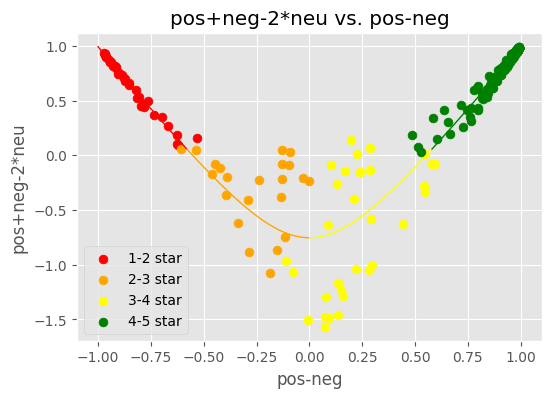

In [34]:
fig = plt.figure(figsize=(6,4))

plt.scatter(rescale_df['pos_neg'][cut1_2_re], rescale_df['pos_neg_2neu'][cut1_2_re], s=40, c='red', marker='o', alpha=1, label = '1-2 star')
plt.scatter(rescale_df['pos_neg'][cut2_3_re], rescale_df['pos_neg_2neu'][cut2_3_re], s=40, c='orange', marker='o', alpha=1, label = '2-3 star')
plt.scatter(rescale_df['pos_neg'][cut3_4_re], rescale_df['pos_neg_2neu'][cut3_4_re], s=40, c='yellow', marker='o', alpha=1, label = '3-4 star')
plt.scatter(rescale_df['pos_neg'][cut4_5_re], rescale_df['pos_neg_2neu'][cut4_5_re], s=40, c='green', marker='o', alpha=1, label = '4-5 star')

plt.plot(xs_hyp[:cutoff_2_3], ys_hyp[:cutoff_2_3], linewidth=1, c='red')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], ys_hyp[cutoff_2_3+1:cutoff_3_4], linewidth=1, c='orange')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], ys_hyp[cutoff_3_4+1:cutoff_4_5], linewidth=1, c='yellow')
plt.plot(xs_hyp[cutoff_4_5+1:], ys_hyp[cutoff_4_5+1:], linewidth=1, c='green')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

#plt.gca().set_aspect('equal')

plt.legend()

plt.show()

It is ok to have dots of one color just over the boundary with another color. \
\
In the example below, the green (4-5 stars) at (0.525, 0.035) is rounded up from about 3.95 stars, which is why it is closer to the yellow portion of the curve.

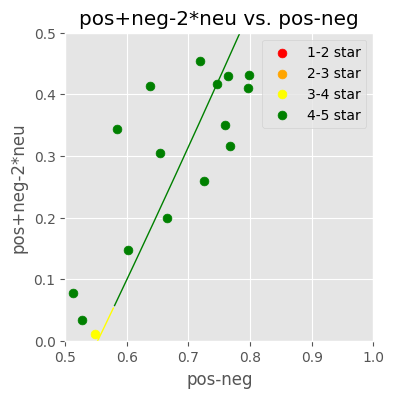

In [35]:
fig = plt.figure(figsize=(6,4))

plt.scatter(rescale_df['pos_neg'][cut1_2_re], rescale_df['pos_neg_2neu'][cut1_2_re], s=40, c='red', marker='o', alpha=1, label = '1-2 star')
plt.scatter(rescale_df['pos_neg'][cut2_3_re], rescale_df['pos_neg_2neu'][cut2_3_re], s=40, c='orange', marker='o', alpha=1, label = '2-3 star')
plt.scatter(rescale_df['pos_neg'][cut3_4_re], rescale_df['pos_neg_2neu'][cut3_4_re], s=40, c='yellow', marker='o', alpha=1, label = '3-4 star')
plt.scatter(rescale_df['pos_neg'][cut4_5_re], rescale_df['pos_neg_2neu'][cut4_5_re], s=40, c='green', marker='o', alpha=1, label = '4-5 star')

plt.plot(xs_hyp[:cutoff_2_3], ys_hyp[:cutoff_2_3], linewidth=1, c='red')
plt.plot(xs_hyp[cutoff_2_3+1:cutoff_3_4], ys_hyp[cutoff_2_3+1:cutoff_3_4], linewidth=1, c='orange')
plt.plot(xs_hyp[cutoff_3_4+1:cutoff_4_5], ys_hyp[cutoff_3_4+1:cutoff_4_5], linewidth=1, c='yellow')
plt.plot(xs_hyp[cutoff_4_5+1:], ys_hyp[cutoff_4_5+1:], linewidth=1, c='green')

plt.title('pos+neg-2*neu vs. pos-neg')
plt.xlabel('pos-neg')
plt.ylabel('pos+neg-2*neu')

plt.gca().set_aspect('equal')

plt.xlim(0.5, 1.)
plt.ylim(0., .5)

plt.legend()

plt.show()

## Roberta star rankings for each original star ranking

<Axes: xlabel='rating', ylabel='new_stars'>

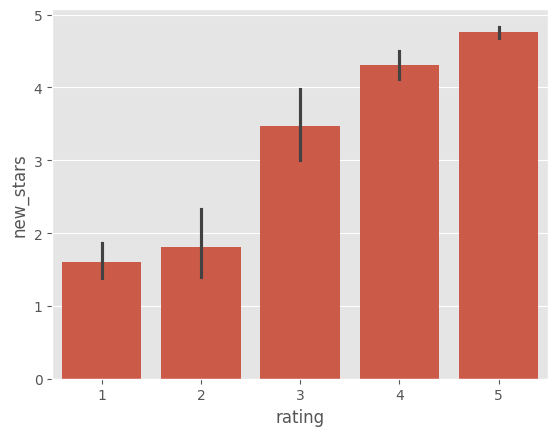

In [36]:
sns.barplot(data=rescale_df, x='rating', y='new_stars')

## Get the new star rating of the restaurant

In [37]:
rating_new = np.round(np.mean(rescale_df['new_stars'].values), 3)
rating_old = np.round(np.mean(df['rating'].values), 3)
rating_old_com = np.round(np.mean(df_com['rating'].values), 3)
print(f'The old rating calculated from available reviews was {rating_old} stars')
print(f'The old rating from just reviews with comments was {rating_old_com} stars')
print(f'The new RoBERTa rating is {rating_new} stars!')

The old rating calculated from available reviews was 4.346 stars
The old rating from just reviews with comments was 4.189 stars
The new RoBERTa rating is 4.194 stars!
